# Stat 236 Final Project

- data source (filtering on HoR): https://www.govtrack.us/congress/votes#chamber[]=2
- compare DCMM results with baseline and https://www.thelugarcenter.org/ourwork-Bipartisan-Index.html

In [77]:
import pandas as pd
import numpy as np
import os
import openai
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

In [190]:
client = OpenAI(api_key='API_KEY_HERE')

### data scraping

getting past 5 years of HoR roll-call voting data (each year has many csv's where each file corresponds to a bill that's voted on)

In [ ]:
import requests
import os

def download_csv_from_bill_page(bill_number, year, session):
    base_url = f"https://www.govtrack.us/congress/votes/{session}-{year}/h"
    bill_url = f"{base_url}{bill_number}"
    
    directory = f'csv_files/{session}-{year}'
    if not os.path.exists(directory):
        os.makedirs(directory)

    try:
        response = requests.get(bill_url, timeout=60) 
        
        if response.status_code == 200:
            csv_url = f"{bill_url}/export/csv"
            csv_name = f"congress_votes_{session}_{year}_h{bill_number}.csv"

            print(f"Downloading {csv_name} from {csv_url}")
            csv_response = requests.get(csv_url, timeout=60)  

            with open(f'{directory}/{csv_name}', 'wb') as file:
                file.write(csv_response.content)
                print(f"Saved {csv_name} in {directory}")
        else:
            print(f"Bill {bill_number} not found (Status code: {response.status_code})")
    
    except requests.exceptions.Timeout:
        print(f"Timeout for bill {bill_number}. Skipping...")
    
    except requests.exceptions.RequestException as e:
        print(f"Error for bill {bill_number}: {e}. Skipping...")


def download_csvs(start, end, year, session):
    for bill_number in range(start, end + 1):
        download_csv_from_bill_page(bill_number, year, session)

In [ ]:
start = 1  
end = 455  
year = 2024  
session = 118 

download_csvs(start, end, year, session)

In [ ]:
start = 525  
end = 724  
year = 2023  
session = 118 

download_csvs(start, end, year, session)

In [ ]:
start = 1
end = 549
year = 2022
session = 117

download_csvs(start, end, year, session)

In [ ]:
start = 1
end = 449
year = 2021
session = 117

download_csvs(start, end, year, session)

In [ ]:
start = 1
end = 253
year = 2020
session = 116

download_csvs(start, end, year, session)

In [ ]:
start = 1
end = 701
year = 2019
session = 116

download_csvs(start, end, year, session)

### data cleaning

filtering with GPT3.5 for substantive voting topics

In [4]:
def is_substantive_topic(topic):
    messages = [
        {
            "role": "system",
            "content": "You are a classifier that determines whether a U.S. House of Representatives voting topic is substantive or procedural/miscellaneous. "
                       "Classify topics related to laws, policies, regulations, government programs, national security, the economy, and civil rights as substantive. "
                       "Classify routine matters such as attendance, quorum calls, adjournment, and naming post offices as procedural/miscellaneous."
        },
        {
            "role": "user",
            "content": f"""
            Voting topic: "{topic}"

            Based on your classification criteria, is this a substantive voting issue? Please respond with "Yes" if it is substantive, or "No" if it is not.

            Examples:
            - Substantive Vote Examples: "Health care reform act", "Tax cuts for small businesses", "Funding for national defense".
            - Non-Substantive/Procedural Vote Examples: "Adjournment", "Quorum call", "Attendance", "Naming a post office", "Motion to table".
            """
        }
    ]
    
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=messages,
        max_tokens=10,
        temperature=0
    )

    classification = completion.choices[0].message.content.strip().lower()
    return "yes" in classification

In [5]:
def filter_votes_by_substance(session, year, margin_threshold=20, topic_column='topic'):
    folder_path = f'csv_files/{session}-{year}'
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            
            title_df = pd.read_csv(file_path)
            title = title_df.columns[0]  
            
            df = pd.read_csv(file_path, header=1)
            df.attrs['title'] = title
            
            print(f"Processing file: {filename}")

            if df.attrs['title'] and is_substantive_topic(df.attrs['title']):
                df.to_csv(f'csv_files/{session}-{year}/cleaned', index=False)
            else:
                continue

In [ ]:
filter_votes_by_substance(session=118, year=2024)

In [ ]:
filter_votes_by_substance(session=118, year=2023)

### eda

(1) examining distribution of voting margins / learning where to set "cutoff" for polarizing bills
- votes are typically of margin of 1, especially right before elections
- polarization increases over time
  
(2) examining those who vote higher proportion outside of their party vote
- visualized in next section (serves as baseline to DCMM results)

In [253]:
def plot_voting_margin_distribution(session, year):
    folder_path = f'csv_files/{session}-{year}/cleaned'
    
    margins = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)

            if 'vote' not in df.columns:
                print(f"Skipping {filename}: no 'vote' column found.")
                continue

            vote_counts = df['vote'].value_counts()
            yea_votes = vote_counts.get('Yea', 0)
            nay_votes = vote_counts.get('Nay', 0)
            
            margin = abs(yea_votes - nay_votes)
            margins.append(margin)

    plt.figure(figsize=(10, 6))
    sns.histplot(margins, bins=30, kde=False, color='skyblue')
    plt.title(f'Distribution of Voting Margins in Session {session}, Year {year}', fontsize=16)
    plt.xlabel('Voting Margin (|Yea - Nay|)', fontsize=14)
    plt.ylabel('Number of Bills', fontsize=14)
    plt.grid(True)
    plt.show()

    print(f"Median Voting Margin: {pd.Series(margins).median()}")
    print(f"Mean Voting Margin: {pd.Series(margins).mean()}")

    margins_below_30 = [margin for margin in margins if margin < 30]

    plt.figure(figsize=(10, 6))
    sns.histplot(margins_below_30, bins=29, kde=False, color='skyblue')
    plt.title(f'Distribution of Voting Margins (Less than 30) in Session {session}, Year {year}', fontsize=16)
    plt.xlabel('Voting Margin (|Yea - Nay|)', fontsize=14)
    plt.ylabel('Number of Bills', fontsize=14)
    plt.grid(True)
    plt.show()

    return margins

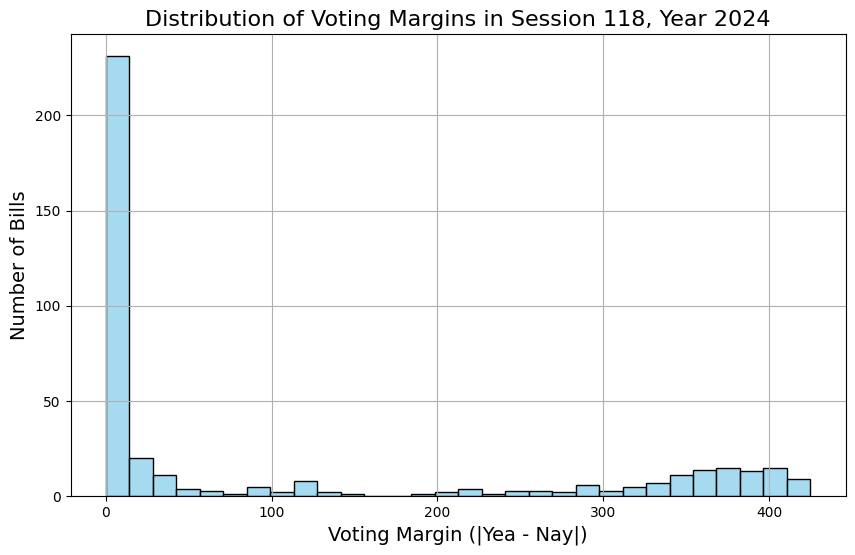

Median Voting Margin: 8.0
Mean Voting Margin: 108.43034825870647


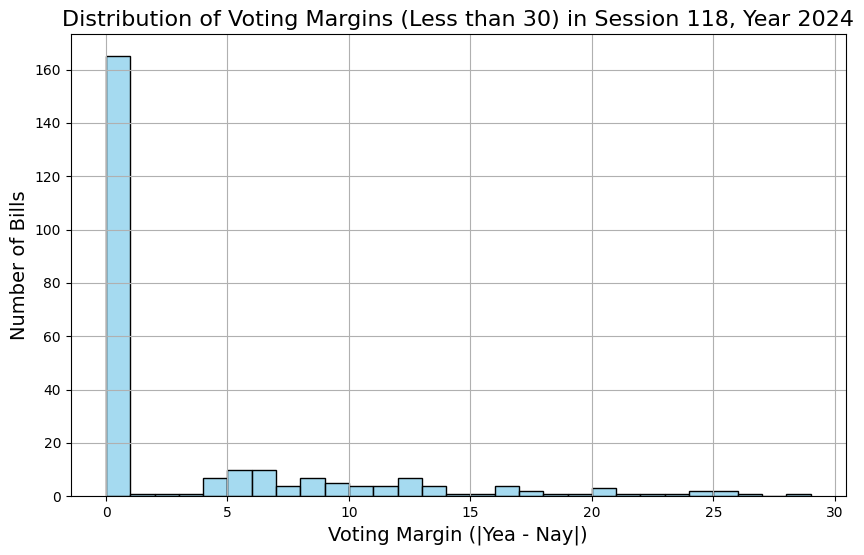

In [254]:
session = 118  
year = 2024  
margins = plot_voting_margin_distribution(session, year)

Skipping congress_votes_118_2023_h219.csv: no 'vote' column found.


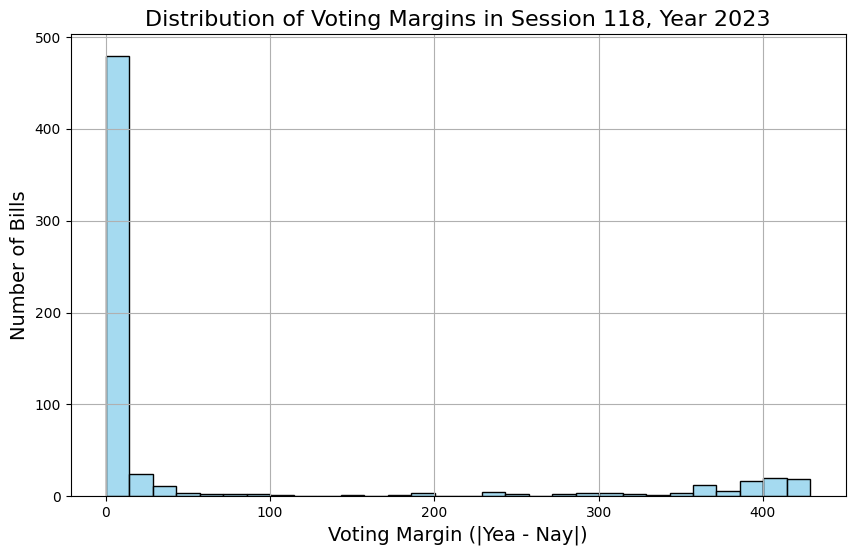

Median Voting Margin: 0.0
Mean Voting Margin: 62.87400318979267


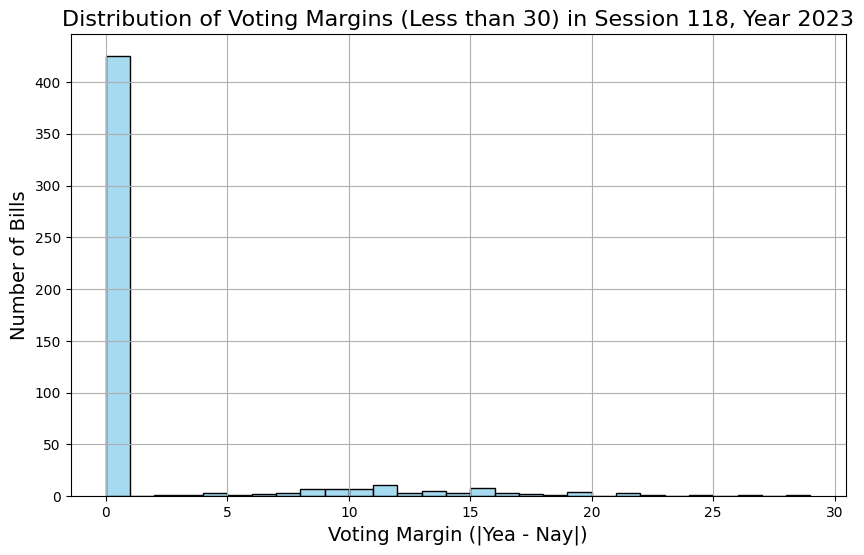

In [257]:
session = 118  
year = 2023  
margins = plot_voting_margin_distribution(session, year)

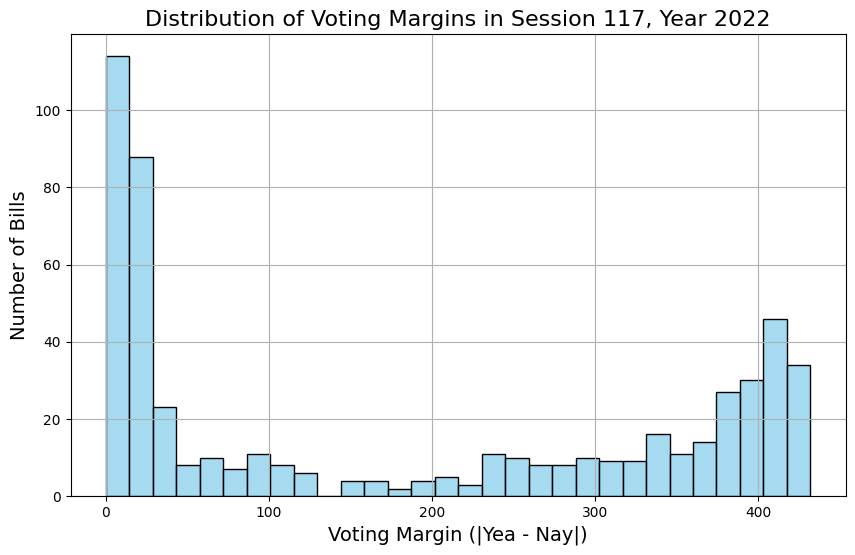

Median Voting Margin: 117.5
Mean Voting Margin: 184.92222222222222


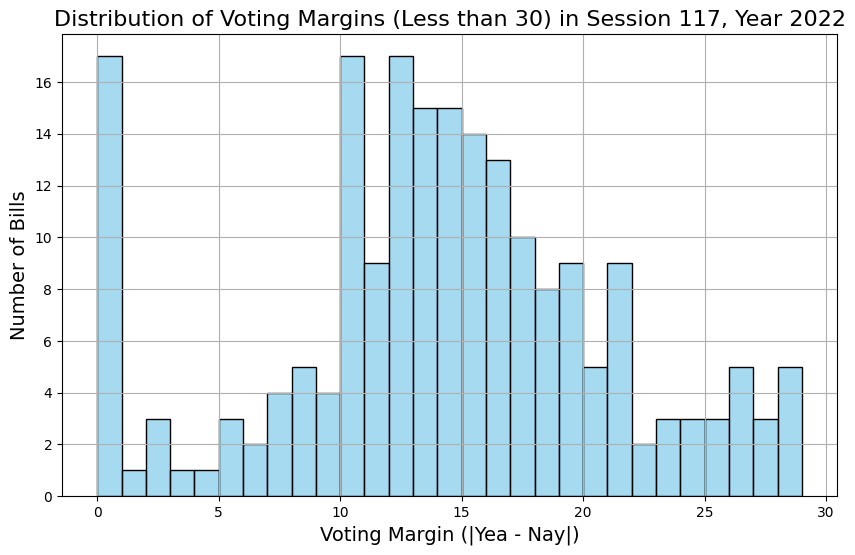

In [143]:
session = 117  
year = 2022  
margins = plot_voting_margin_distribution(session, year)

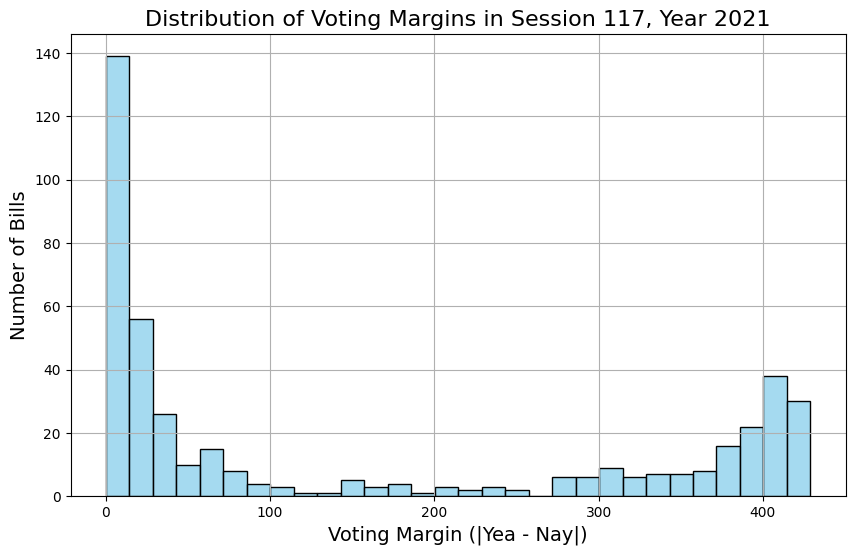

Median Voting Margin: 42.0
Mean Voting Margin: 157.29478458049886


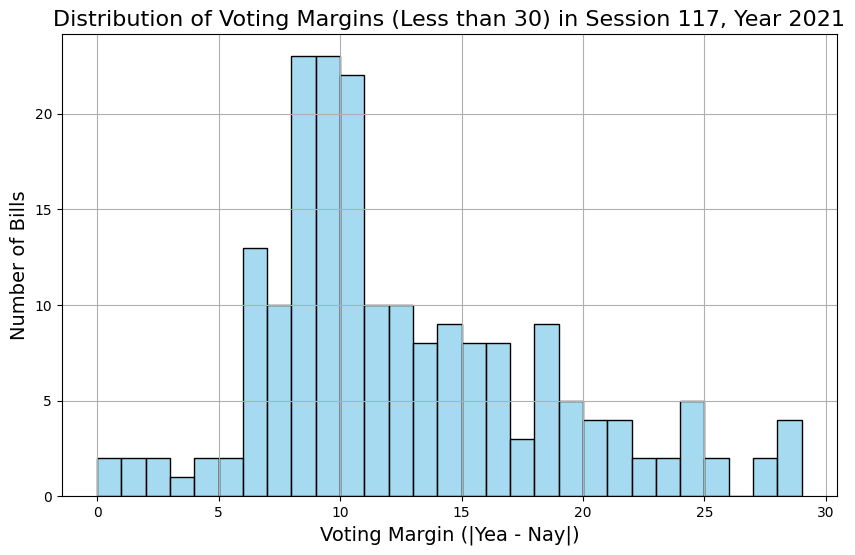

In [144]:
session = 117  
year = 2021
margins = plot_voting_margin_distribution(session, year)

Skipping congress_votes_116_2020_h225.csv: no 'vote' column found.


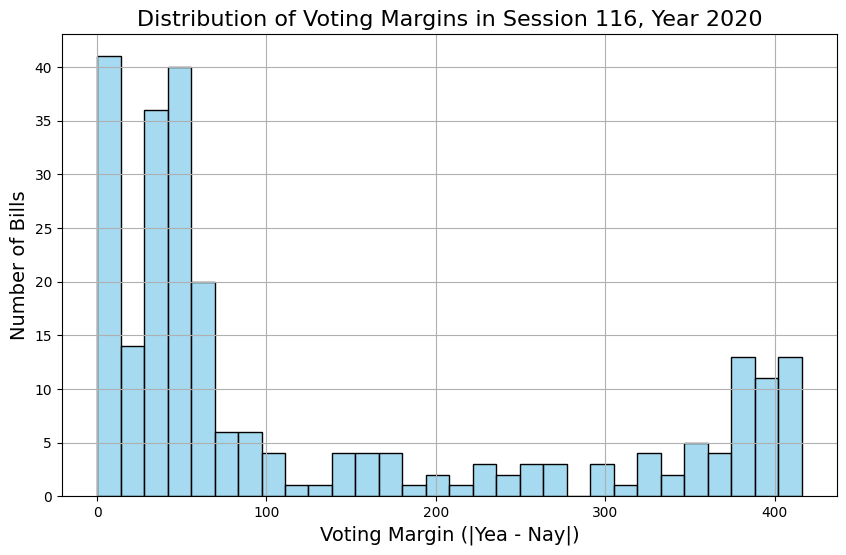

Median Voting Margin: 54.0
Mean Voting Margin: 130.78571428571428


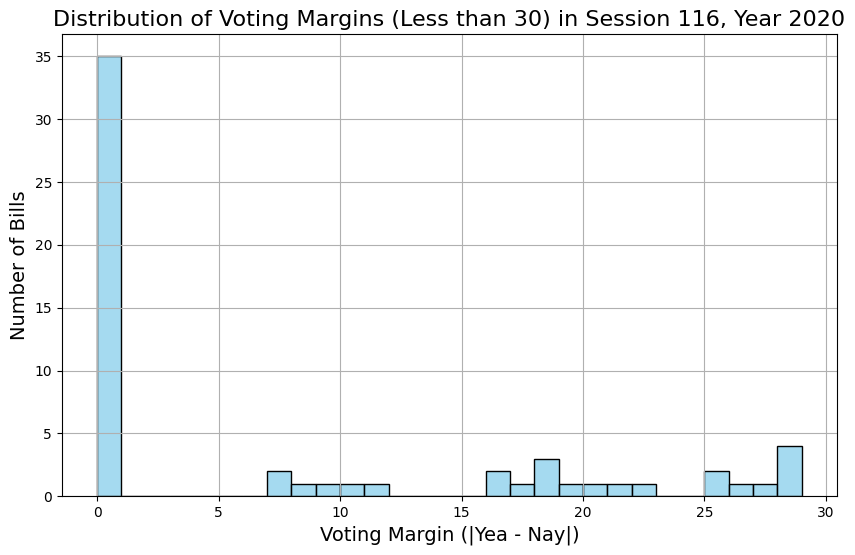

In [145]:
session = 116  
year = 2020  
margins = plot_voting_margin_distribution(session, year)

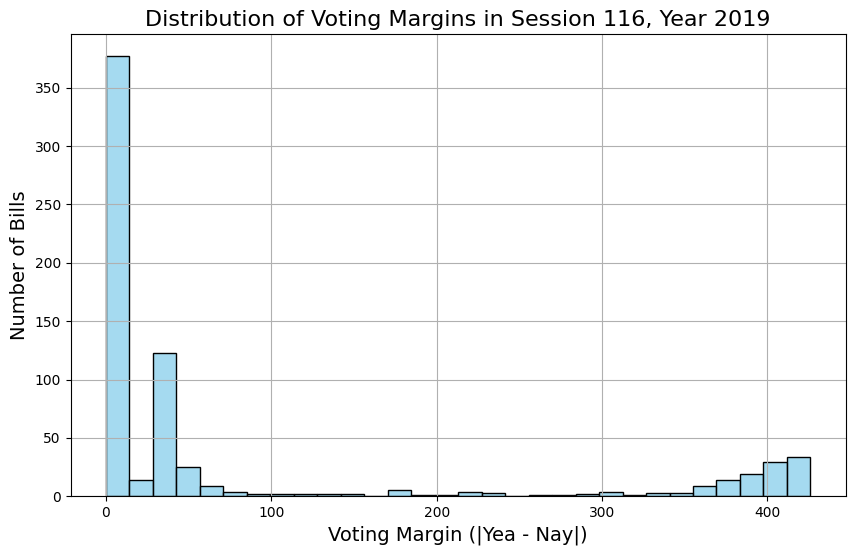

Median Voting Margin: 0.0
Mean Voting Margin: 82.74281609195403


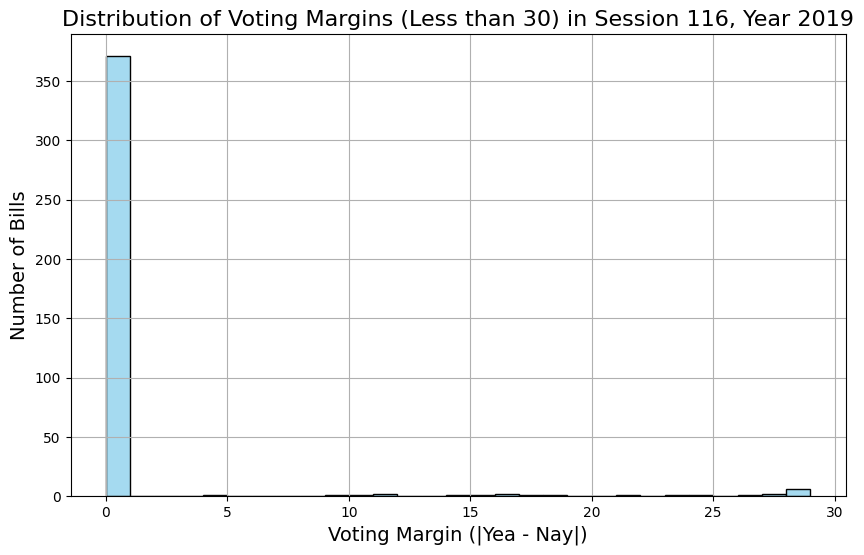

In [146]:
session = 116  
year = 2019  
margins = plot_voting_margin_distribution(session, year)

### matrix construction

creating and exporting binary similarity matrix (threshold=0.5)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_similarity_matrix_with_parties(session, year1, year2):
    votes = {}
    parties = {}

    folder_path = f'csv_files/{session}-{year1}/cleaned'
    # Iterate through CSV files
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)

            if 'vote' not in df.columns or 'party' not in df.columns or 'name' not in df.columns:
                print(f"Skipping {filename}: Missing required columns.")
                continue

            # Collect votes and parties for each representative
            for _, row in df.iterrows():
                name = row['name']
                vote = row['vote']
                party = row['party']

                normalized_vote = 1 if vote in ['Aye', 'Yea'] else 0
                if name not in votes:
                    votes[name] = []
                    parties[name] = party
                votes[name].append(normalized_vote)

    folder_path = f'csv_files/{session}-{year2}/cleaned'
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)

            if 'vote' not in df.columns or 'party' not in df.columns or 'name' not in df.columns:
                print(f"Skipping {filename}: Missing required columns.")
                continue

            # Collect votes and parties for each representative
            for _, row in df.iterrows():
                name = row['name']
                vote = row['vote']
                party = row['party']

                normalized_vote = 1 if vote in ['Aye', 'Yea'] else 0
                if name not in votes:
                    votes[name] = []
                    parties[name] = party
                votes[name].append(normalized_vote)
                
    # Convert votes to DataFrame
    votes_df = pd.DataFrame.from_dict(votes, orient='index').fillna(-1)
    representatives = votes_df.index
    n = len(representatives)
    similarity_matrix = np.zeros((n, n))

    # Compute similarity matrix
    for i, rep_i in enumerate(representatives):
        for j, rep_j in enumerate(representatives):
            if i <= j:
                votes_i = votes_df.loc[rep_i]
                votes_j = votes_df.loc[rep_j]
                valid_votes = (votes_i != -1) & (votes_j != -1)
                matches = (votes_i[valid_votes] == votes_j[valid_votes]).sum()
                total_comparisons = valid_votes.sum()
                similarity = matches / total_comparisons if total_comparisons > 0 else 0
                similarity_matrix[i, j] = similarity_matrix[j, i] = similarity

    # Convert similarity matrix to DataFrame
    similarity_df = pd.DataFrame(similarity_matrix, index=representatives, columns=representatives)

    # Create party-based matrices
    party_series = pd.Series(parties)
    republicans = party_series[party_series == 'Republican'].index
    democrats = party_series[party_series == 'Democrat'].index

    republican_matrix = similarity_df.loc[republicans, republicans]
    democrat_matrix = similarity_df.loc[democrats, democrats]

    return similarity_df, republican_matrix, democrat_matrix, party_series

In [2]:
session = 118
year1 = 2023
year2 = 2024
similarity_df, republican_matrix, democrat_matrix, party_series = calculate_similarity_matrix_with_parties(session, year1, year2)

Skipping congress_votes_118_2023_h219.csv: Missing required columns.


In [3]:
similarity_df.head()

,Rep. Robert Aderholt [R],Rep. Sanford Bishop [D],Rep. Earl Blumenauer [D],Rep. Michael Burgess [R],Rep. Ken Calvert [R],Rep. John R. Carter [R],Rep. Ed Case [D],Rep. James “Jim” Clyburn [D],Rep. Tom Cole [R],Rep. Danny Davis [D],...,"Rep. Chris Stewart [R, 2013-2023]",Rep. Mike Johnson [R],Rep. Gabe Amo [D],Rep. Celeste Maloy [R],Rep. Thomas Suozzi [D],Rep. Timothy Kennedy [D],Rep. Vince Fong [R],Rep. Michael Rulli [R],Rep. Greg Lopez [R],Rep. LaMonica McIver [D]
Rep. Robert Aderholt [R],1.000000,0.363460,0.306122,0.849368,0.876579,0.825073,0.372206,0.339164,0.853256,0.315841,...,0.521341,0.580822,0.531780,0.532731,0.481690,0.458678,0.528497,0.586667,0.635514,0.538462
Rep. Sanford Bishop [D],0.363460,1.000000,0.894072,0.292517,0.461613,0.433431,0.940719,0.958212,0.459670,0.917396,...,0.503049,0.430137,0.533898,0.465011,0.498592,0.533058,0.445596,0.460000,0.355140,0.307692
Rep. Earl Blumenauer [D],0.306122,0.894072,1.000000,0.241011,0.400389,0.378037,0.885326,0.926142,0.423712,0.916424,...,0.512195,0.398630,0.538136,0.444695,0.515493,0.545455,0.445596,0.426667,0.317757,0.384615
Rep. Michael Burgess [R],0.849368,0.292517,0.241011,1.000000,0.801749,0.794947,0.303207,0.264334,0.776482,0.244898,...,0.521341,0.616438,0.495763,0.634312,0.459155,0.421488,0.544041,0.653333,0.719626,0.538462
Rep. Ken Calvert [R],0.876579,0.461613,0.400389,0.801749,1.000000,0.872692,0.472303,0.437318,0.947522,0.410107,...,0.512195,0.526027,0.542373,0.519187,0.459155,0.471074,0.507772,0.566667,0.588785,0.538462


In [4]:
similarity_df.describe()

,Rep. Robert Aderholt [R],Rep. Sanford Bishop [D],Rep. Earl Blumenauer [D],Rep. Michael Burgess [R],Rep. Ken Calvert [R],Rep. John R. Carter [R],Rep. Ed Case [D],Rep. James “Jim” Clyburn [D],Rep. Tom Cole [R],Rep. Danny Davis [D],...,"Rep. Chris Stewart [R, 2013-2023]",Rep. Mike Johnson [R],Rep. Gabe Amo [D],Rep. Celeste Maloy [R],Rep. Thomas Suozzi [D],Rep. Timothy Kennedy [D],Rep. Vince Fong [R],Rep. Michael Rulli [R],Rep. Greg Lopez [R],Rep. LaMonica McIver [D]
count,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,...,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000
mean,0.596936,0.617558,0.583685,0.563285,0.631034,0.602906,0.617893,0.611718,0.622065,0.594662,...,0.517554,0.508113,0.523321,0.518467,0.493688,0.491944,0.492696,0.527326,0.511169,0.444064
std,0.246452,0.296862,0.304681,0.281063,0.197725,0.190449,0.289241,0.314462,0.184029,0.309232,...,0.034095,0.096283,0.035518,0.074863,0.032896,0.056327,0.058838,0.087448,0.163587,0.142008
min,0.272109,0.166181,0.155491,0.197279,0.346939,0.338192,0.174927,0.141885,0.366375,0.157434,...,0.384146,0.319527,0.384615,0.338600,0.384615,0.364486,0.357513,0.333333,0.280374,0.230769
25%,0.344995,0.336249,0.283124,0.273212,0.439261,0.412051,0.346939,0.310010,0.444275,0.294461,...,0.503049,0.420548,0.510593,0.460497,0.476056,0.442149,0.450777,0.446667,0.355140,0.307692
50%,0.532731,0.510204,0.473275,0.544041,0.556122,0.540254,0.518950,0.497041,0.556851,0.482993,...,0.515244,0.495890,0.529661,0.485327,0.495775,0.495868,0.471503,0.533333,0.514019,0.384615
75%,0.851312,0.929057,0.904762,0.851312,0.829932,0.799806,0.921283,0.942663,0.805637,0.920311,...,0.530488,0.608219,0.540254,0.589165,0.509859,0.537190,0.544041,0.606667,0.672897,0.538462
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


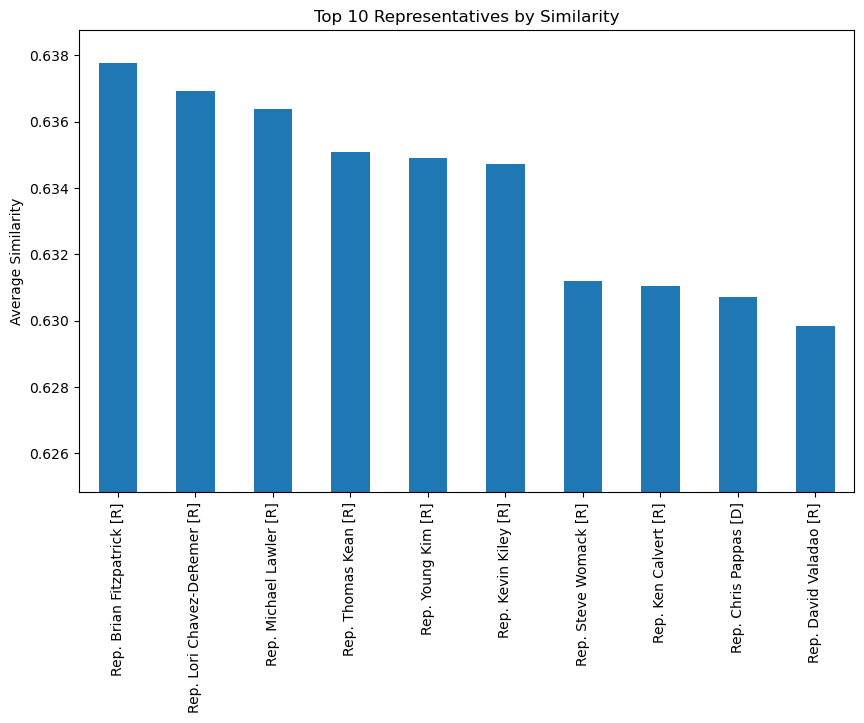

In [5]:
# Calculate average similarity for each representative
average = similarity_df.mean(axis=1)

# Sort representatives by average similarity
sorted_averages = average.sort_values(ascending=False).head(10)

sorted_averages.plot(kind='bar', figsize=(10, 6), title=f'Top 10 Representatives by Similarity')
plt.ylabel('Average Similarity')
plt.ylim(sorted_averages.min() - 0.005, sorted_averages.max() + 0.001)
plt.show()

In [6]:
republican_matrix.head()

,Rep. Robert Aderholt [R],Rep. Michael Burgess [R],Rep. Ken Calvert [R],Rep. John R. Carter [R],Rep. Tom Cole [R],Rep. Mario Diaz-Balart [R],Rep. Kay Granger [R],Rep. Sam Graves [R],Rep. Darrell Issa [R],Rep. Frank Lucas [R],...,Rep. Wesley Hunt [R],Rep. Jennifer Kiggans [R],Rep. Derrick Van Orden [R],Rep. Harriet Hageman [R],"Rep. Chris Stewart [R, 2013-2023]",Rep. Mike Johnson [R],Rep. Celeste Maloy [R],Rep. Vince Fong [R],Rep. Michael Rulli [R],Rep. Greg Lopez [R]
Rep. Robert Aderholt [R],1.000000,0.849368,0.876579,0.825073,0.853256,0.840622,0.754130,0.874636,0.880466,0.841594,...,0.781341,0.838678,0.854227,0.807580,0.521341,0.580822,0.532731,0.528497,0.586667,0.635514
Rep. Michael Burgess [R],0.849368,1.000000,0.801749,0.794947,0.776482,0.754130,0.710398,0.846453,0.840622,0.778426,...,0.825073,0.765792,0.831876,0.884354,0.521341,0.616438,0.634312,0.544041,0.653333,0.719626
Rep. Ken Calvert [R],0.876579,0.801749,1.000000,0.872692,0.947522,0.903790,0.770651,0.844509,0.854227,0.930029,...,0.718173,0.934888,0.864917,0.726919,0.512195,0.526027,0.519187,0.507772,0.566667,0.588785
Rep. John R. Carter [R],0.825073,0.794947,0.872692,1.000000,0.847425,0.805637,0.734694,0.822157,0.808552,0.859086,...,0.701652,0.846453,0.832847,0.749271,0.527439,0.526027,0.505643,0.471503,0.533333,0.635514
Rep. Tom Cole [R],0.853256,0.776482,0.947522,0.847425,1.000000,0.915452,0.780369,0.817298,0.830904,0.912536,...,0.706511,0.913508,0.829932,0.707483,0.524390,0.515068,0.519187,0.502591,0.600000,0.588785


In [7]:
republican_matrix.describe()

,Rep. Robert Aderholt [R],Rep. Michael Burgess [R],Rep. Ken Calvert [R],Rep. John R. Carter [R],Rep. Tom Cole [R],Rep. Mario Diaz-Balart [R],Rep. Kay Granger [R],Rep. Sam Graves [R],Rep. Darrell Issa [R],Rep. Frank Lucas [R],...,Rep. Wesley Hunt [R],Rep. Jennifer Kiggans [R],Rep. Derrick Van Orden [R],Rep. Harriet Hageman [R],"Rep. Chris Stewart [R, 2013-2023]",Rep. Mike Johnson [R],Rep. Celeste Maloy [R],Rep. Vince Fong [R],Rep. Michael Rulli [R],Rep. Greg Lopez [R]
count,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,...,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000
mean,0.828853,0.829826,0.808647,0.778812,0.786933,0.770880,0.715833,0.830030,0.829674,0.784545,...,0.778454,0.777970,0.811664,0.812897,0.530823,0.592090,0.578957,0.534272,0.602828,0.660654
std,0.082407,0.083343,0.101731,0.079041,0.096052,0.085962,0.062154,0.081751,0.078952,0.096401,...,0.080349,0.100274,0.079921,0.097512,0.039246,0.056150,0.054513,0.048623,0.048914,0.072975
min,0.420118,0.337278,0.453865,0.469428,0.466334,0.469428,0.429980,0.406312,0.404339,0.438903,...,0.370809,0.441397,0.398422,0.347140,0.414634,0.366864,0.345372,0.357513,0.360000,0.289720
25%,0.812439,0.807580,0.759961,0.758017,0.735666,0.728863,0.694849,0.811467,0.810496,0.736638,...,0.743440,0.721088,0.799806,0.758989,0.518293,0.561644,0.553047,0.507772,0.580000,0.626168
50%,0.851312,0.850340,0.828960,0.796890,0.804665,0.786200,0.724976,0.850340,0.851312,0.803693,...,0.799806,0.793003,0.833819,0.831876,0.530488,0.606849,0.589165,0.538860,0.606667,0.672897
75%,0.874636,0.878523,0.878523,0.826045,0.851312,0.827017,0.753158,0.877551,0.872692,0.852284,...,0.832847,0.846453,0.854227,0.884354,0.539634,0.626027,0.609481,0.559585,0.626667,0.710280
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
democrat_matrix.head()

,Rep. Sanford Bishop [D],Rep. Earl Blumenauer [D],Rep. Ed Case [D],Rep. James “Jim” Clyburn [D],Rep. Danny Davis [D],Rep. Diana DeGette [D],Rep. Rosa DeLauro [D],Rep. Lloyd Doggett [D],Rep. Anna Eshoo [D],Rep. Raúl Grijalva [D],...,Rep. Jasmine Crockett [D],Rep. Gregorio Casar [D],Rep. Becca Balint [D],Rep. Marie Gluesenkamp Perez [D],Rep. Jennifer McClellan [D],"Rep. David Cicilline [D, 2011-2023]",Rep. Gabe Amo [D],Rep. Thomas Suozzi [D],Rep. Timothy Kennedy [D],Rep. LaMonica McIver [D]
Rep. Sanford Bishop [D],1.000000,0.894072,0.940719,0.958212,0.917396,0.940719,0.955296,0.921283,0.947522,0.778426,...,0.935860,0.898931,0.929057,0.792031,0.571888,0.408163,0.533898,0.498592,0.533058,0.307692
Rep. Earl Blumenauer [D],0.894072,1.000000,0.885326,0.926142,0.916424,0.926142,0.913508,0.930029,0.907677,0.829932,...,0.929057,0.919339,0.930029,0.724976,0.565451,0.397959,0.538136,0.515493,0.545455,0.384615
Rep. Ed Case [D],0.940719,0.885326,1.000000,0.941691,0.906706,0.922255,0.946550,0.906706,0.932945,0.773567,...,0.927114,0.886297,0.914480,0.804665,0.577253,0.428571,0.527542,0.504225,0.545455,0.307692
Rep. James “Jim” Clyburn [D],0.958212,0.926142,0.941691,1.000000,0.947522,0.959184,0.964043,0.945578,0.952381,0.806608,...,0.965986,0.931001,0.951409,0.775510,0.566524,0.418367,0.529661,0.507042,0.541322,0.307692
Rep. Danny Davis [D],0.917396,0.916424,0.906706,0.947522,1.000000,0.943635,0.931001,0.937804,0.923226,0.826045,...,0.956268,0.927114,0.941691,0.746356,0.560086,0.418367,0.531780,0.504225,0.528926,0.230769


In [9]:
democrat_matrix.describe()

,Rep. Sanford Bishop [D],Rep. Earl Blumenauer [D],Rep. Ed Case [D],Rep. James “Jim” Clyburn [D],Rep. Danny Davis [D],Rep. Diana DeGette [D],Rep. Rosa DeLauro [D],Rep. Lloyd Doggett [D],Rep. Anna Eshoo [D],Rep. Raúl Grijalva [D],...,Rep. Jasmine Crockett [D],Rep. Gregorio Casar [D],Rep. Becca Balint [D],Rep. Marie Gluesenkamp Perez [D],Rep. Jennifer McClellan [D],"Rep. David Cicilline [D, 2011-2023]",Rep. Gabe Amo [D],Rep. Thomas Suozzi [D],Rep. Timothy Kennedy [D],Rep. LaMonica McIver [D]
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.905447,0.881589,0.898180,0.917717,0.896099,0.910380,0.912933,0.902405,0.908901,0.779380,...,0.913025,0.887265,0.907120,0.766327,0.565644,0.416806,0.538454,0.512427,0.540575,0.327972
std,0.090188,0.083587,0.087131,0.092238,0.091860,0.091487,0.090815,0.090435,0.090812,0.067563,...,0.093107,0.089487,0.091742,0.068373,0.037144,0.047539,0.035285,0.035260,0.034063,0.070645
min,0.307692,0.384615,0.307692,0.307692,0.230769,0.307692,0.307692,0.307692,0.307692,0.377551,...,0.307692,0.307692,0.307692,0.384615,0.307692,0.372449,0.384615,0.384615,0.461538,0.230769
25%,0.910836,0.876579,0.900875,0.918367,0.892857,0.907920,0.913508,0.899903,0.912536,0.768465,...,0.910350,0.877308,0.901846,0.753644,0.560086,0.403061,0.529661,0.504225,0.533058,0.307692
50%,0.930029,0.906220,0.921283,0.943149,0.920311,0.935860,0.937804,0.928086,0.935374,0.794947,...,0.938776,0.910593,0.932945,0.776482,0.565451,0.413265,0.536017,0.509859,0.537190,0.307692
75%,0.941691,0.921283,0.933916,0.957240,0.937804,0.950680,0.951409,0.942663,0.945821,0.810739,...,0.954325,0.931001,0.949951,0.797862,0.569742,0.423469,0.544492,0.515493,0.545455,0.307692
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# SAVE CONTINUOUS SIMILARITY MATRIX

similarity_df.to_csv("cont_similarity_matrix_2023_2024.csv")
similarity_df

,Rep. Robert Aderholt [R],Rep. Sanford Bishop [D],Rep. Earl Blumenauer [D],Rep. Michael Burgess [R],Rep. Ken Calvert [R],Rep. John R. Carter [R],Rep. Ed Case [D],Rep. James “Jim” Clyburn [D],Rep. Tom Cole [R],Rep. Danny Davis [D],...,"Rep. Chris Stewart [R, 2013-2023]",Rep. Mike Johnson [R],Rep. Gabe Amo [D],Rep. Celeste Maloy [R],Rep. Thomas Suozzi [D],Rep. Timothy Kennedy [D],Rep. Vince Fong [R],Rep. Michael Rulli [R],Rep. Greg Lopez [R],Rep. LaMonica McIver [D]
Rep. Robert Aderholt [R],1.000000,0.363460,0.306122,0.849368,0.876579,0.825073,0.372206,0.339164,0.853256,0.315841,...,0.521341,0.580822,0.531780,0.532731,0.481690,0.458678,0.528497,0.586667,0.635514,0.538462
Rep. Sanford Bishop [D],0.363460,1.000000,0.894072,0.292517,0.461613,0.433431,0.940719,0.958212,0.459670,0.917396,...,0.503049,0.430137,0.533898,0.465011,0.498592,0.533058,0.445596,0.460000,0.355140,0.307692
Rep. Earl Blumenauer [D],0.306122,0.894072,1.000000,0.241011,0.400389,0.378037,0.885326,0.926142,0.423712,0.916424,...,0.512195,0.398630,0.538136,0.444695,0.515493,0.545455,0.445596,0.426667,0.317757,0.384615
Rep. Michael Burgess [R],0.849368,0.292517,0.241011,1.000000,0.801749,0.794947,0.303207,0.264334,0.776482,0.244898,...,0.521341,0.616438,0.495763,0.634312,0.459155,0.421488,0.544041,0.653333,0.719626,0.538462
Rep. Ken Calvert [R],0.876579,0.461613,0.400389,0.801749,1.000000,0.872692,0.472303,0.437318,0.947522,0.410107,...,0.512195,0.526027,0.542373,0.519187,0.459155,0.471074,0.507772,0.566667,0.588785,0.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rep. Timothy Kennedy [D],0.458678,0.533058,0.545455,0.421488,0.471074,0.475207,0.545455,0.541322,0.466942,0.528926,...,0.475207,0.442149,0.561983,0.396694,0.549587,1.000000,0.414508,0.433333,0.364486,0.461538
Rep. Vince Fong [R],0.528497,0.445596,0.445596,0.544041,0.507772,0.471503,0.445596,0.455959,0.502591,0.445596,...,0.585492,0.616580,0.430052,0.554404,0.450777,0.414508,1.000000,0.600000,0.598131,0.846154
Rep. Michael Rulli [R],0.586667,0.460000,0.426667,0.653333,0.566667,0.533333,0.446667,0.473333,0.600000,0.433333,...,0.626667,0.600000,0.393333,0.640000,0.440000,0.433333,0.600000,1.000000,0.654206,0.615385
Rep. Greg Lopez [R],0.635514,0.355140,0.317757,0.719626,0.588785,0.635514,0.355140,0.336449,0.588785,0.336449,...,0.654206,0.635514,0.476636,0.719626,0.457944,0.364486,0.598131,0.654206,1.000000,0.692308


In [51]:
# SAVE BINARY SIMILARITY MATRIX

def apply_similarity_threshold(similarity_df, threshold):
    """
    Apply a threshold to the similarity matrix.
    Entries above the threshold are set to 1, and below are set to 0.
    """
    binary_similarity_df = (similarity_df >= threshold).astype(int)
    return binary_similarity_df


threshold = 0.5  # PARAMETER TUNING HERE
binary_similarity_df = apply_similarity_threshold(similarity_df, threshold)
binary_similarity_df.to_csv("binary_similarity_matrix_2023_2024.csv")
binary_similarity_df

,Rep. Robert Aderholt [R],Rep. Sanford Bishop [D],Rep. Earl Blumenauer [D],Rep. Michael Burgess [R],Rep. Ken Calvert [R],Rep. John R. Carter [R],Rep. Ed Case [D],Rep. James “Jim” Clyburn [D],Rep. Tom Cole [R],Rep. Danny Davis [D],...,"Rep. Chris Stewart [R, 2013-2023]",Rep. Mike Johnson [R],Rep. Gabe Amo [D],Rep. Celeste Maloy [R],Rep. Thomas Suozzi [D],Rep. Timothy Kennedy [D],Rep. Vince Fong [R],Rep. Michael Rulli [R],Rep. Greg Lopez [R],Rep. LaMonica McIver [D]
Rep. Robert Aderholt [R],1,0,0,1,1,1,0,0,1,0,...,1,1,1,1,0,0,1,1,1,1
Rep. Sanford Bishop [D],0,1,1,0,0,0,1,1,0,1,...,1,0,1,0,0,1,0,0,0,0
Rep. Earl Blumenauer [D],0,1,1,0,0,0,1,1,0,1,...,1,0,1,0,1,1,0,0,0,0
Rep. Michael Burgess [R],1,0,0,1,1,1,0,0,1,0,...,1,1,0,1,0,0,1,1,1,1
Rep. Ken Calvert [R],1,0,0,1,1,1,0,0,1,0,...,1,1,1,1,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rep. Timothy Kennedy [D],0,1,1,0,0,0,1,1,0,1,...,0,0,1,0,1,1,0,0,0,0
Rep. Vince Fong [R],1,0,0,1,1,0,0,0,1,0,...,1,1,0,1,0,0,1,1,1,1
Rep. Michael Rulli [R],1,0,0,1,1,1,0,0,1,0,...,1,1,0,1,0,0,1,1,1,1
Rep. Greg Lopez [R],1,0,0,1,1,1,0,0,1,0,...,1,1,0,1,0,0,1,1,1,1
